In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json

In [2]:
!gdown "19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t"
!gdown "1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=19FAA4_z7xzdqqtwnkLRL2oI4PuMWPYBZ&confirm=t
To: /content/Dataset.zip
100% 845M/845M [00:05<00:00, 147MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ixS6ump2gFwwChlg4vrGyVa_9t0csLKd&confirm=t
To: /content/Patterns.zip
100% 271M/271M [00:01<00:00, 200MB/s]


In [ ]:
!unzip /content/Dataset.zip -d Dataset
!unzip /content/Patterns.zip -d Patterns

In [12]:
img_name = "/content/Dataset/1644369905.2248352.jpg"
json_name = img_name[:-3] + "json"

# Viewing images

{'version': '4.6.0', 'flags': {}, 'shapes': [{'label': 'tarak', 'points': [[601.7306518554688, 881.9729614257812], [601.5123291015625, 872.555908203125], [562.017578125, 871.9315185546875], [474.8360290527344, 881.3365478515625], [375.8370056152344, 889.7183837890625], [263.3363952636719, 896.5235595703125], [265.79681396484375, 909.27978515625], [352.12384033203125, 903.2999877929688], [472.6170959472656, 900.92919921875], [549.15576171875, 886.494384765625]], 'group_id': None, 'shape_type': 'polygon', 'flags': {}}], 'imagePath': '1644369905.2248352.jpg', 'imageData': None, 'imageHeight': 2048, 'imageWidth': 2592, 'pattern': 'AYLIN.tif'}


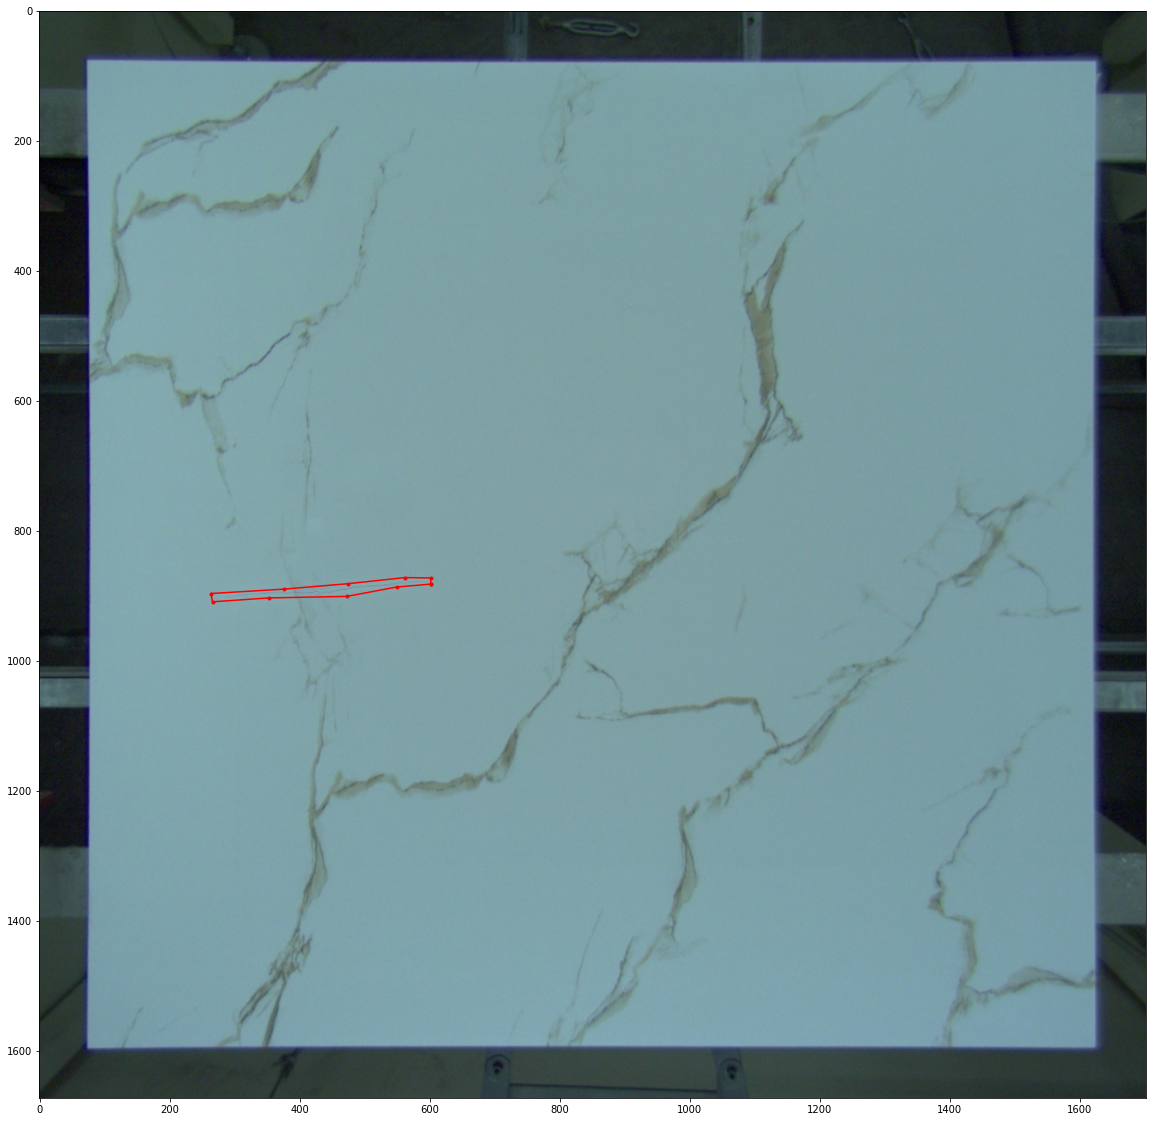

In [13]:
img = cv2.imread(img_name)

f = open(json_name, encoding="utf8")
data = json.load(f)
print(data)
f.close()

plt.figure(figsize=(20, 20))
plt.imshow(img[..., ::-1])

for shape in data["shapes"]:
  points = np.array(shape['points'])
  ind = list(np.arange(points.shape[0])) + [0]
  plt.plot(points[ind, 0], points[ind, 1], 'r.-')
  # plt.plot(points[-1:-3:-1, 0], points[-1:-3:-1, 1], 'r')

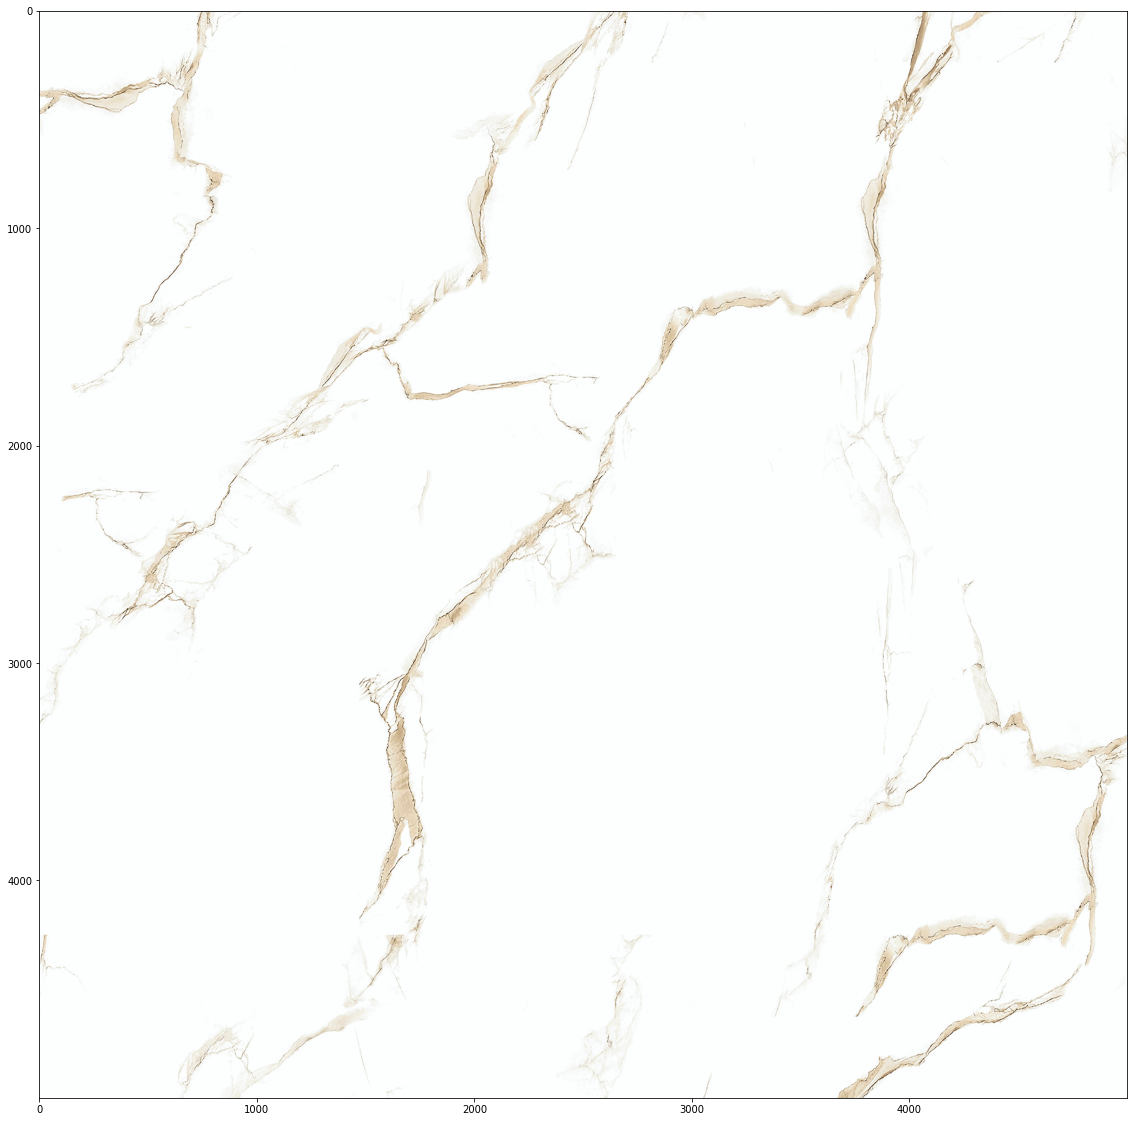

In [ ]:
pattern = cv.imread('/content/Patterns/' + data['pattern'])

plt.figure(figsize=(20, 20))
plt.imshow(pattern[..., ::-1])

# Histogram matching

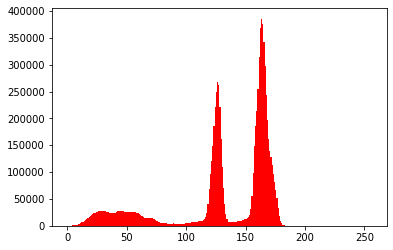

In [14]:
# Histogram of an image
plt.hist(img.flatten(),256,[0,256], color = 'r')
plt.show()

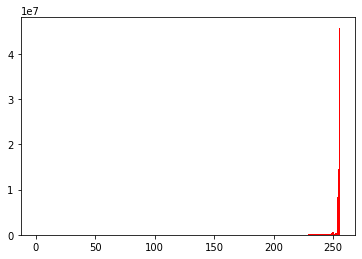

In [45]:
# Histogram of pattern
pat = cv2.imread("/content/Patterns/AYLIN.tif")
plt.hist(pat.flatten(),256,[0,256], color = 'r')
plt.show()

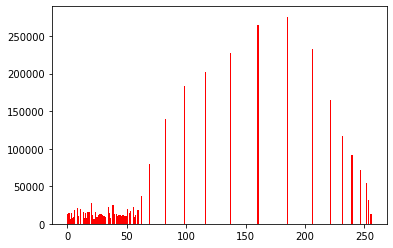

In [60]:
from skimage import exposure
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_pat = cv2.cvtColor(pat, cv2.COLOR_BGR2GRAY)

img_equ = cv2.equalizeHist(gray_img)
pat_equ = cv2.equalizeHist(gray_pat)

matched = exposure.match_histograms(img_equ , pat_equ)

plt.hist(matched.flatten(),256,[0,256], color = 'r')
plt.show()
# plt.imshow(matched, cmap="gray")

# Finding key points
We should use key points to match the pictures to patterns 

In [50]:
matched.shape

(1673, 1703)

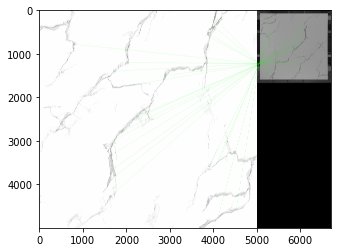

(<matplotlib.image.AxesImage at 0x7f7efc32f190>, None)

In [62]:
MIN_MATCH_COUNT = 10

sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray_pat,None)
kp2, des2 = sift.detectAndCompute(gray_img,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = gray_pat.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(gray_pat,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(gray_pat,kp1,gray_img,kp2,good,None,**draw_params)
plt.imshow(img3, 'gray'),plt.show()

# Binary shits

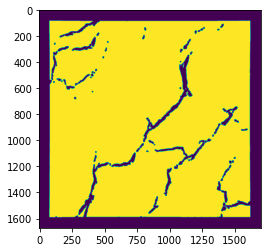

In [21]:
# ret,otsu_thresh = cv2.threshold(gray,127,200,cv2.THRESH_BINARY)
gray = cv2.cvtColor(img[..., ::-1], cv2.COLOR_BGR2GRAY)
ret,otsu_thresh = cv2.threshold(gray,127,200,cv2.THRESH_BINARY)

dilation = cv2.erode(otsu_thresh,np.ones((9,9)),iterations = 1)

plt.imshow(dilation)

# What network to use ??
